# National Median Classification Model

The purpose of this notebook is to create a classification model to predict whether or not a city's suicide rate is bigger than the national median of rates.

Cities whose suicide rate is less than or equal to the national median are labeled 0, and cities whose suicide rate is greater than the national median are labeled 1.

The features used for this model are the disease rates from the previous year for that city, as well as the state where it is located.

---

Import libraries

In [1]:
import pandas as pd
import numpy as np

# DataPrep
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Tuning
from skopt import gp_minimize
# Feature Selection
from sklearn.feature_selection import RFE,SelectFromModel
# Models
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from mixed_naive_bayes import MixedNB

# Evaluation
from sklearn import metrics

# Plotting
import sys
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geoplot
import mapclassify
sys.path.append(os.path.abspath('..'))
%matplotlib inline

import time
import glob
import shap
root = "../../"

In [2]:
dict_uf_cod = {11: 'RO', 12: 'AC', 13: 'AM', 14: 'RR', 15: 'PA', 16: 'AP', 17: 'TO',
21: 'MA', 22: 'PI', 23: 'CE', 24: 'RN', 25: 'PB', 26: 'PE', 27: 'AL', 28: 'SE',
29: 'BA', 31: 'MG', 32: 'ES', 33: 'RJ', 35: 'SP', 41: 'PR', 42: 'SC', 43: 'RS',
50: 'MS', 51: 'MT', 52: 'GO', 53: 'DF'}

# DataPrep
*You can skip this and load the csv directly after this section*

---

## DataPrep (models)

Getting a list of all diseases

In [3]:
disease = ""
path = root + "CSV/TabNet/Internacoes_Rate/"
all_files = glob.glob(path + "*.csv")
suicide = pd.read_csv(root +'CSV/Suicide/suicide_rates_08_18.csv', index_col=0)

years = [str(x).zfill(2) for x in range(8,19)]
columns = ["RATE_" + year for year in years]
columns.append("MUNCOD")

disease_list = []

for file in all_files:
    file_name = file.split("\\")[-1]
    disease = file_name.split(".csv")[0]
    disease_df = pd.read_csv(file, sep=',', index_col=0)
    if(set(disease_df.columns) == set(columns)):
        disease_list.append(disease)
print(len(disease_list), " diseases")

313  diseases


Creating dataframe by using only rows with **at least 80% values that are not NaN** 

In [4]:
initial_df = pd.DataFrame()
percentage_valid_values = 0.8
for i in range(0,len(years)-1):
    col_year_suicide = "RATE_" + years[i+1]
    year_df = suicide[[col_year_suicide, "MUNCOD"]].copy()
    
    for disease in disease_list:
        col_year_disease = "RATE_" + years[i]
        disease_df = pd.read_csv(path + disease + ".csv", sep=',', index_col=0)
        disease_df = disease_df[[col_year_disease, "MUNCOD"]]
        disease_df[disease] = disease_df[col_year_disease] 
        disease_df = disease_df.drop(columns={col_year_disease})
        year_df = pd.merge(disease_df, year_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
    N = int(year_df.shape[1]*percentage_valid_values)
    year_df = year_df.dropna(thresh=N) # a column needs at least N non-NaNs to survive
    year_df["TARGET"] = (year_df[col_year_suicide] > year_df[col_year_suicide].median()).astype(int)
    year_df = year_df.drop(columns=col_year_suicide)
    initial_df = pd.concat([initial_df, year_df])

initial_df.head()

,MUNCOD,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,...,ANEMIA_POR_DEFICIÊNCIA_DE_FERRO,ANCILOSTOMÍASE,AMEBÍASE,ALGUNS_TRANSTORNOS_ENVOLVENDO_MECANISMO_IMUNITÁRIO,AFECÇ_HEMORRÁG_E_OUTR_DOENÇ_SANG_E_ÓRG_HEMATOPOÉT,ACID_VASCULAR_CEREBR_NÃO_ESPEC_HEMORRÁG_OU_ISQUÊM,ACID_VASCULAR_CEREBR_ISQUÊM_TRANSIT_E_SÍNDR_CORREL,ABORTO_POR_RAZÕES_MÉDICAS,ABORTO_ESPONTÂNEO,TARGET
0,110001,28.481914,40.688449,0.0,142.409570,NaN,NaN,NaN,0.0,NaN,...,0.000000,NaN,0.000000,NaN,44.757293,40.688449,32.550759,NaN,126.134191,1
1,110002,9.458389,54.385737,0.0,15.369882,NaN,0.0,NaN,0.0,0.0,...,0.000000,NaN,0.000000,0.0,1.182299,39.015855,0.000000,0.0,1.182299,0
3,110004,5.110972,21.721631,0.0,63.887150,NaN,NaN,NaN,0.0,0.0,...,2.555486,NaN,NaN,0.0,3.833229,106.052669,3.833229,0.0,2.555486,1
8,110009,0.000000,48.921969,0.0,24.460985,NaN,NaN,NaN,0.0,NaN,...,0.000000,NaN,0.000000,NaN,3.494426,0.000000,17.472132,0.0,0.000000,1
9,110010,2.466639,9.866555,0.0,12.333194,NaN,0.0,0.0,0.0,0.0,...,41.932858,0.0,2.466639,NaN,2.466639,36.999581,0.000000,0.0,197.331097,1


Filling NaN values with zero and getting state code from MUNCOD column

In [5]:
df = initial_df.copy()

# Fill NaN values with 0
df = df.fillna(0)

# Get MUNCOD from UF
df['UF'] = df['MUNCOD'] / 10000
df['UF'] = df['UF'].astype(int)
df['UF'].replace(dict_uf_cod, inplace=True)
dummy = pd.get_dummies(df['UF'])
df = pd.concat([df, dummy], axis=1)
df = df.drop(['MUNCOD', 'UF'], axis=1)
df.head()

,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,TUBERCULOSE_DO_SISTEMA_NERVOSO,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
0,28.481914,40.688449,0.0,142.409570,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,9.458389,54.385737,0.0,15.369882,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,5.110972,21.721631,0.0,63.887150,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
8,0.000000,48.921969,0.0,24.460985,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
9,2.466639,9.866555,0.0,12.333194,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [6]:
df.to_csv("df_classification_highest_rates.csv")

## DataPrep (2018 predictions)

Getting training data (2008-2017)

In [7]:
train_df = pd.DataFrame()
percentage_valid_values = 0.8
for i in range(0,len(years)-2):
    col_year_suicide = "RATE_" + years[i+1]
    year_df = suicide[[col_year_suicide, "MUNCOD"]].copy()
    
    for disease in disease_list:
        col_year_disease = "RATE_" + years[i]
        disease_df = pd.read_csv(path + disease + ".csv", sep=',', index_col=0)
        disease_df = disease_df[[col_year_disease, "MUNCOD"]]
        disease_df[disease] = disease_df[col_year_disease] 
        disease_df = disease_df.drop(columns={col_year_disease})
        year_df = pd.merge(disease_df, year_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
    N = int(year_df.shape[1]*percentage_valid_values)
    year_df = year_df.dropna(thresh=N) # a column needs at least N non-NaNs to survive
    year_df["TARGET"] = (year_df[col_year_suicide] > year_df[col_year_suicide].median()).astype(int)
    year_df = year_df.drop(columns=col_year_suicide)
    train_df = pd.concat([train_df, year_df])

train_df.head()

,MUNCOD,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,...,ANEMIA_POR_DEFICIÊNCIA_DE_FERRO,ANCILOSTOMÍASE,AMEBÍASE,ALGUNS_TRANSTORNOS_ENVOLVENDO_MECANISMO_IMUNITÁRIO,AFECÇ_HEMORRÁG_E_OUTR_DOENÇ_SANG_E_ÓRG_HEMATOPOÉT,ACID_VASCULAR_CEREBR_NÃO_ESPEC_HEMORRÁG_OU_ISQUÊM,ACID_VASCULAR_CEREBR_ISQUÊM_TRANSIT_E_SÍNDR_CORREL,ABORTO_POR_RAZÕES_MÉDICAS,ABORTO_ESPONTÂNEO,TARGET
0,110001,28.481914,40.688449,0.0,142.409570,NaN,NaN,NaN,0.0,NaN,...,0.000000,NaN,0.000000,NaN,44.757293,40.688449,32.550759,NaN,126.134191,1
1,110002,9.458389,54.385737,0.0,15.369882,NaN,0.0,NaN,0.0,0.0,...,0.000000,NaN,0.000000,0.0,1.182299,39.015855,0.000000,0.0,1.182299,0
3,110004,5.110972,21.721631,0.0,63.887150,NaN,NaN,NaN,0.0,0.0,...,2.555486,NaN,NaN,0.0,3.833229,106.052669,3.833229,0.0,2.555486,1
8,110009,0.000000,48.921969,0.0,24.460985,NaN,NaN,NaN,0.0,NaN,...,0.000000,NaN,0.000000,NaN,3.494426,0.000000,17.472132,0.0,0.000000,1
9,110010,2.466639,9.866555,0.0,12.333194,NaN,0.0,0.0,0.0,0.0,...,41.932858,0.0,2.466639,NaN,2.466639,36.999581,0.000000,0.0,197.331097,1


In [8]:
# Fill NaN values with 0
train_df = train_df.fillna(0)

# Get MUNCOD from UF
train_df['UF'] = train_df['MUNCOD'] / 10000
train_df['UF'] = train_df['UF'].astype(int)
train_df['UF'].replace(dict_uf_cod, inplace=True)
dummy = pd.get_dummies(train_df['UF'])
train_df = pd.concat([train_df, dummy], axis=1)
train_df = train_df.drop(['MUNCOD', 'UF'], axis=1)
train_df.head()

,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,TUBERCULOSE_DO_SISTEMA_NERVOSO,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
0,28.481914,40.688449,0.0,142.409570,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
1,9.458389,54.385737,0.0,15.369882,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,5.110972,21.721631,0.0,63.887150,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
8,0.000000,48.921969,0.0,24.460985,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
9,2.466639,9.866555,0.0,12.333194,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [9]:
train_df.to_csv("train_data_classification_highest_rates.csv")

Getting testing data (2018)

In [10]:
percentage_valid_values = 0.8
test_df = suicide[["RATE_18", "MUNCOD"]].copy()
col_year_suicide = "RATE_18"    
for disease in disease_list:
    col_year_disease = "RATE_17"
    disease_df = pd.read_csv(path + disease + ".csv", sep=',', index_col=0)
    disease_df = disease_df[[col_year_disease, "MUNCOD"]]
    disease_df[disease] = disease_df[col_year_disease] 
    disease_df = disease_df.drop(columns={col_year_disease})
    test_df = pd.merge(disease_df, test_df, left_on="MUNCOD", right_on="MUNCOD", how='right')
N = int(year_df.shape[1]*percentage_valid_values)
test_df = test_df.dropna(thresh=N) # a column needs at least N non-NaNs to survive
test_df["TARGET"] = (test_df[col_year_suicide] > test_df[col_year_suicide].median()).astype(int)
test_df = test_df.drop(columns=col_year_suicide)
test_df.head()

,MUNCOD,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,...,ANEMIA_POR_DEFICIÊNCIA_DE_FERRO,ANCILOSTOMÍASE,AMEBÍASE,ALGUNS_TRANSTORNOS_ENVOLVENDO_MECANISMO_IMUNITÁRIO,AFECÇ_HEMORRÁG_E_OUTR_DOENÇ_SANG_E_ÓRG_HEMATOPOÉT,ACID_VASCULAR_CEREBR_NÃO_ESPEC_HEMORRÁG_OU_ISQUÊM,ACID_VASCULAR_CEREBR_ISQUÊM_TRANSIT_E_SÍNDR_CORREL,ABORTO_POR_RAZÕES_MÉDICAS,ABORTO_ESPONTÂNEO,TARGET
0,110001,19.656406,23.587687,19.656406,231.945591,NaN,NaN,NaN,11.793844,NaN,...,0.000000,NaN,0.000000,NaN,55.037937,70.763062,3.931281,NaN,19.656406,0
1,110002,8.384182,13.973636,1.863152,32.605152,NaN,0.000000,NaN,1.863152,0.000000,...,0.931576,NaN,29.810424,0.0,13.042061,71.731334,3.726303,0.0,39.126182,0
3,110004,9.038833,20.337374,3.389562,42.934457,NaN,NaN,NaN,0.000000,2.259708,...,0.000000,NaN,NaN,0.0,11.298541,73.440519,1.129854,0.0,5.649271,1
8,110009,3.027551,12.110203,3.027551,6.055101,NaN,NaN,NaN,0.000000,NaN,...,9.082652,NaN,0.000000,NaN,9.082652,45.413261,39.358159,0.0,15.137754,1
9,110010,2.107437,0.000000,2.107437,14.752060,NaN,2.107437,0.0,2.107437,0.000000,...,21.074371,0.0,2.107437,NaN,21.074371,18.966934,0.000000,0.0,219.173463,1


In [11]:
# Fill NaN values with 0
test_df = test_df.fillna(0)

# Get MUNCOD from UF
test_df['UF'] = test_df['MUNCOD'] / 10000
test_df['UF'] = test_df['UF'].astype(int)
test_df['UF'].replace(dict_uf_cod, inplace=True)
dummy = pd.get_dummies(test_df['UF'])
test_df = pd.concat([test_df, dummy], axis=1)
test_df = test_df.drop(['UF'], axis=1)
test_df.head()

,MUNCOD,ÚLCERA_GÁSTRICA_E_DUODENAL,VEIAS_VARICOSAS_DAS_EXTREMIDADES_INFERIORES,VARICELA_E_HERPES_ZOSTER,UROLITÍASE,TÉTANO_NEONATAL,TUBERC_INTEST_PERITÔNIO_GLÂNGL_MESENTÉRICOS,TUBERCULOSE_ÓSSEA_E_DAS_ARTICULAÇÕES,TUBERCULOSE_PULMONAR,TUBERCULOSE_MILIAR,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
0,110001,19.656406,23.587687,19.656406,231.945591,0.0,0.000000,0.0,11.793844,0.000000,...,0,0,0,1,0,0,0,0,0,0
1,110002,8.384182,13.973636,1.863152,32.605152,0.0,0.000000,0.0,1.863152,0.000000,...,0,0,0,1,0,0,0,0,0,0
3,110004,9.038833,20.337374,3.389562,42.934457,0.0,0.000000,0.0,0.000000,2.259708,...,0,0,0,1,0,0,0,0,0,0
8,110009,3.027551,12.110203,3.027551,6.055101,0.0,0.000000,0.0,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,0
9,110010,2.107437,0.000000,2.107437,14.752060,0.0,2.107437,0.0,2.107437,0.000000,...,0,0,0,1,0,0,0,0,0,0


In [12]:
test_df.to_csv("test_data_classification_highest_rates.csv")

# Model

In [3]:
df = pd.read_csv("df_classification_highest_rates.csv",index_col=0)
train_df = pd.read_csv("train_data_classification_highest_rates.csv", index_col=0)
test_df = pd.read_csv("test_data_classification_highest_rates.csv", index_col=0)

Checking the number of 0s and 1s in TARGET column

In [4]:
unique, counts = np.unique(df["TARGET"].values, return_counts=True)
dict(zip(unique, counts))

{0: 4680, 1: 4670}

Defining X and y

In [15]:
X = df.drop(columns=["TARGET"])
y = df["TARGET"]

X.shape

(9350, 340)

Defining some functions

In [5]:
def get_average_feat_importance(feature_importance_list):
    final_feat_df = pd.DataFrame()
    for i, feat_df in enumerate(feature_importance_list):
        feat_df = feat_df.rename(columns={"Importance": i})
        if final_feat_df.empty:
            final_feat_df = feat_df
        else:
            final_feat_df = pd.merge(final_feat_df, feat_df, on="Feature", how="right")
    final_feat_df = final_feat_df.fillna(0)
    final_feat_df["Avg_importance"] = final_feat_df.sum(axis=1)/(final_feat_df.shape[1] -1)
    final_feat_df = final_feat_df[["Feature", "Avg_importance"]]
    return final_feat_df.sort_values(by="Avg_importance", ascending=False)

In [6]:
def sfm_feature_selector(X_train,y_train):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100))
    embeded_rf_selector.fit(X_train, y_train)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features (SFM)')
    return embeded_rf_feature

In [7]:
def get_average(scores_list):
    scores_avg_test = []
    for i in range(len(scores_list[0])):
        arr_list = [x[i] for x in scores_list]
        avg_result = np.array(arr_list).mean(axis=0)
        scores_avg_test.append(avg_result)
    return scores_avg_test

In [8]:
def calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores=None):
    print("Train")
    print(metrics.confusion_matrix(y_train, y_pred_train))
    print(metrics.classification_report(y_train, y_pred_train, digits=3, zero_division=0))
    print("Test")
    print(metrics.confusion_matrix(y_test, y_pred))
    print(metrics.classification_report(y_test, y_pred, digits=3, zero_division=0))
    if scores is not None:
        scores = scores.append({"accuracy_train": metrics.accuracy_score(y_train,y_pred_train),
                      "accuracy_test": metrics.accuracy_score(y_test,y_pred),
                      "scores_train": metrics.precision_recall_fscore_support(y_train,y_pred_train, zero_division=0),
                      "scores_test": metrics.precision_recall_fscore_support(y_test,y_pred, zero_division=0)}, ignore_index=True)
        return scores

In [9]:
def get_average_metrics(score):
    print("## Train")
    avg_accuracy_train = scores["accuracy_train"].mean()
    avg_score_train = get_average(scores["scores_train"])
    print("accuracy_train:", avg_accuracy_train)
    print("precision_train:", avg_score_train[0].mean())
    print("recall_train:", avg_score_train[1].mean())
    print("f1_score_train:", avg_score_train[2].mean())
    print("## Test")
    avg_accuracy_test = scores["accuracy_test"].mean()
    avg_score_test = get_average(scores["scores_test"])
    print("accuracy_test:", avg_accuracy_test)
    print("precision_test:", avg_score_test[0].mean())
    print("recall_test:", avg_score_test[1].mean())
    print("f1_score_test:", avg_score_test[2].mean())

In [21]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

def anova_feature_selector(X_train, y_train, k="all"):
    fs = SelectKBest(score_func=f_classif, k=k)
    fs.fit(X_train, y_train)
    return fs

In [22]:
all_models_scores = {}

## Naive Bayes

In [23]:
start = time.time()
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
count = 1
for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    classifier = MixedNB(categorical_features=[X.columns.get_loc(col) for col in list(dict_uf_cod.values())]);
    classifier.fit(X,y);
    classifier.predict(X);
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
    
    print("\n")
    count += 1
print("=============== SUMMARY NAIVE BAYES ===============")

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["Naive Bayes"] = scores

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
# Making predictions
# Calculating metrics
Train
[[3744    0]
 [3736    0]]
              precision    recall  f1-score   support

           0      0.501     1.000     0.667      3744
           1      0.000     0.000     0.000      3736

    accuracy                          0.501      7480
   macro avg      0.250     0.500     0.334      7480
weighted avg      0.251     0.501     0.334      7480

Test
[[936   0]
 [934   0]]
              precision    recall  f1-score   support

           0      0.501     1.000     0.667       936
           1      0.000     0.000     0.000       934

    accuracy                          0.501      1870
   macro avg      0.250     0.500     0.334      1870
weighted avg      0.251     0.501     0.334      1870



=============== RUN 2 ===============
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
# Making predictions
# Calculating metrics
Train
[[3

## LogisticRegression Model

### Using MinMax Scaling

In [24]:
start = time.time()
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
count = 1

for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Scaling features")
    mm = MinMaxScaler()
    mm_x = mm.fit(X_train)
    X_train = mm_x.transform(X_train)
    X_test = mm_x.transform(X_test)

    print("# Fitting the model")
    classifier = LogisticRegression(random_state=42)
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
  
    print("\n")
    count += 1
print("=============== SUMMARY LOGISTIC REGRESSION (MINMAX) ===============")

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["Logistic Regression MM"] = scores

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Scaling features
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2671 1073]
 [1117 2619]]
              precision    recall  f1-score   support

           0      0.705     0.713     0.709      3744
           1      0.709     0.701     0.705      3736

    accuracy                          0.707      7480
   macro avg      0.707     0.707     0.707      7480
weighted avg      0.707     0.707     0.707      7480

Test
[[652 284]
 [315 619]]
              precision    recall  f1-score   support

           0      0.674     0.697     0.685       936
           1      0.685     0.663     0.674       934

    accuracy                          0.680      1870
   macro avg      0.680     0.680     0.680      1870
weighted avg      0.680     0.680     0.680      1870



=============== RUN 2 ===============
# Scaling features
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2676 1068]
 [1130 2606]]
          

### Using Standard Scaling

In [25]:
start = time.time()
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
count = 1

for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Scaling features")
    sc = StandardScaler()
    sc_x = sc.fit(X_train)
    X_train = sc_x.transform(X_train)
    X_test = sc_x.transform(X_test)

    print("# Fitting the model")
    classifier = LogisticRegression(max_iter=1000, random_state=42)
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
  
    print("\n")
    count += 1
print("=============== SUMMARY LOGISTIC REGRESSION (STANDARD) ===============")

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["Logistic Regression SC"] = scores

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Scaling features
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2691 1053]
 [1091 2645]]
              precision    recall  f1-score   support

           0      0.712     0.719     0.715      3744
           1      0.715     0.708     0.712      3736

    accuracy                          0.713      7480
   macro avg      0.713     0.713     0.713      7480
weighted avg      0.713     0.713     0.713      7480

Test
[[645 291]
 [317 617]]
              precision    recall  f1-score   support

           0      0.670     0.689     0.680       936
           1      0.680     0.661     0.670       934

    accuracy                          0.675      1870
   macro avg      0.675     0.675     0.675      1870
weighted avg      0.675     0.675     0.675      1870



=============== RUN 2 ===============
# Scaling features
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2687 1057]
 [1124 2612]]
          

### SHAP

# Scaling features
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2664 1080]
 [1115 2621]]
              precision    recall  f1-score   support

           0      0.705     0.712     0.708      3744
           1      0.708     0.702     0.705      3736

    accuracy                          0.707      7480
   macro avg      0.707     0.707     0.707      7480
weighted avg      0.707     0.707     0.707      7480

Test
[[643 293]
 [305 629]]
              precision    recall  f1-score   support

           0      0.678     0.687     0.683       936
           1      0.682     0.673     0.678       934

    accuracy                          0.680      1870
   macro avg      0.680     0.680     0.680      1870
weighted avg      0.680     0.680     0.680      1870

# Feature importance
                                               Feature  Importance
248   EFEITOS_TÓXICOS_SUBST_ORIGEM_PRINC_NÃO-MEDICINAL    1.752069
20   TRANST_DISCAIS_CERVIC_E_OUTR_TRANST_DISC_IN

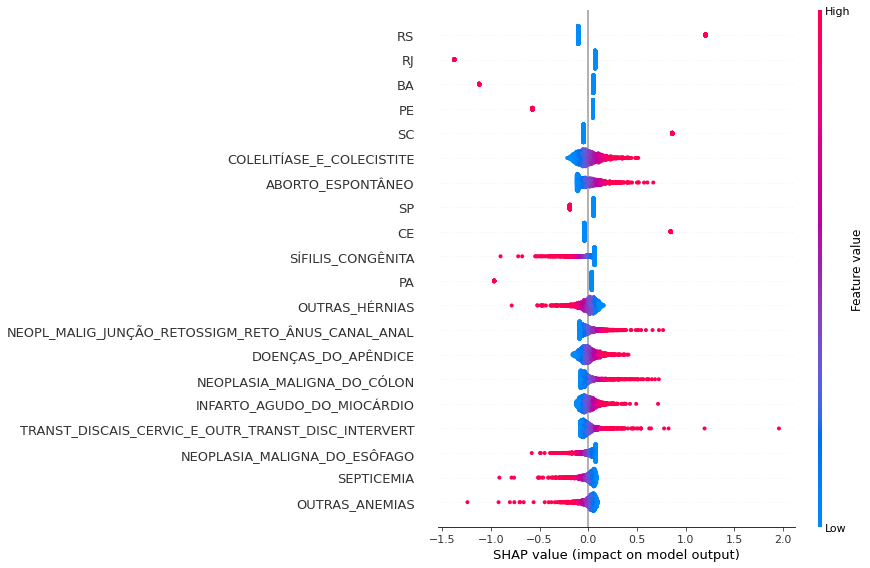

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=1/5, stratify=y)

print("# Scaling features")
mm = MinMaxScaler()
mm_x = mm.fit(X_train)
X_train = pd.DataFrame(mm_x.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(mm_x.transform(X_test), columns=X.columns)
    
print("# Fitting the model")
classifier = LogisticRegression(max_iter=1000,random_state=42)
classifier.fit(X_train, y_train)

print("# Making predictions")
y_pred = classifier.predict(X_test) 
y_pred_train = classifier.predict(X_train)

print("# Calculating metrics")
calculate_metrics(y_train, y_test, y_pred, y_pred_train,None)

print("# Feature importance")
importance = classifier.coef_[0]
important_df  = pd.DataFrame({"Feature": X.columns, "Importance": importance}).sort_values(by="Importance",ascending=False)
print(important_df.head(15))

print("# SHAP analysis")
explainer = shap.LinearExplainer(classifier, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

## Random Forest Model
### No Scaling

In [29]:
start = time.time()
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Feature Selection: SFM")
    selected_sfm_features = sfm_feature_selector(X_train,y_train)
    X_train = X_train[selected_sfm_features]
    X_test = X_test[selected_sfm_features]
    
    print("# Bayesian Optimization")
    def train_model(params):
        n_estimators = params[0]
        max_depth = params[1]
        min_samples_leaf = params[2]
        max_features = params[3]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

        model = RandomForestClassifier(n_jobs=-1, random_state=42,n_estimators=n_estimators, 
                                      max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return metrics.accuracy_score(yf_val, yf_pred)
    space = [
        (5,1000), #n_estimators
        (3,30), #max_depth
        (2,200), #min_samples_leaf
        (0.25,1.00) #max_features
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)
    
    n_estimators = resultado_gp.x[0]
    max_depth = resultado_gp.x[1]
    min_samples_leaf = resultado_gp.x[2]
    max_features = resultado_gp.x[3]
    
    print("# Fitting the model")
    classifier = RandomForestClassifier(random_state=42,n_estimators=n_estimators, 
                                      max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)
    classifier.fit(X_train,y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
    
    print("# Get Feature Importance")
    importance = classifier.feature_importances_
    feature_importance_list.append(pd.DataFrame({"Feature": X_train.columns, "Importance": importance}).sort_values(by="Importance", ascending=False))
    
    print("\n")
    count += 1
print("=============== SUMMARY RANDOM FOREST ===============")
print("# Average Feature Importance")
final_feat_df = get_average_feat_importance(feature_importance_list)
print(final_feat_df.head(20))

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["Random Forest"] = scores

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Feature Selection: SFM
175 selected features (SFM)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2339 1405]
 [1190 2546]]
              precision    recall  f1-score   support

           0      0.663     0.625     0.643      3744
           1      0.644     0.681     0.662      3736

    accuracy                          0.653      7480
   macro avg      0.654     0.653     0.653      7480
weighted avg      0.654     0.653     0.653      7480

Test
[[584 352]
 [343 591]]
              precision    recall  f1-score   support

           0      0.630     0.624     0.627       936
           1      0.627     0.633     0.630       934

    accuracy                          0.628      1870
   macro avg      0.628     0.628     0.628      1870
weighted avg      0.628     0.628     0.628      1870

# Get Feature Importance


=============== RUN 2 ===============
# Feature Selection: SFM
177 selected feat

The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2588 1156]
 [1463 2273]]
              precision    recall  f1-score   support

           0      0.639     0.691     0.664      3744
           1      0.663     0.608     0.634      3736

    accuracy                          0.650      7480
   macro avg      0.651     0.650     0.649      7480
weighted avg      0.651     0.650     0.649      7480

Test
[[623 313]
 [359 575]]
              precision    recall  f1-score   support

           0      0.634     0.666     0.650       936
           1      0.648     0.616     0.631       934

    accuracy                          0.641      1870
   macro avg      0.641     0.641     0.640      1870
weighted avg      0.641     0.641     0.640      1870

# Get Feature Importance


=============== RUN 3 ===============
# Feature Selection: SFM
178 selected features (SFM)
# Bayesian Optimization


The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2525 1219]
 [1419 2317]]
              precision    recall  f1-score   support

           0      0.640     0.674     0.657      3744
           1      0.655     0.620     0.637      3736

    accuracy                          0.647      7480
   macro avg      0.648     0.647     0.647      7480
weighted avg      0.648     0.647     0.647      7480

Test
[[642 294]
 [364 570]]
              precision    recall  f1-score   support

           0      0.638     0.686     0.661       936
           1      0.660     0.610     0.634       934

    accuracy                          0.648      1870
   macro avg      0.649     0.648     0.648      1870
weighted avg      0.649     0.648     0.648      1870

# Get Feature Importance


=============== RUN 4 ===============
# Feature Selection: SFM
173 selected features (SFM)
# Bayesian Optimization


The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2412 1332]
 [1344 2392]]
              precision    recall  f1-score   support

           0      0.642     0.644     0.643      3744
           1      0.642     0.640     0.641      3736

    accuracy                          0.642      7480
   macro avg      0.642     0.642     0.642      7480
weighted avg      0.642     0.642     0.642      7480

Test
[[564 372]
 [330 604]]
              precision    recall  f1-score   support

           0      0.631     0.603     0.616       936
           1      0.619     0.647     0.632       934

    accuracy                          0.625      1870
   macro avg      0.625     0.625     0.624      1870
weighted avg      0.625     0.625     0.624      1870

# Get Feature Importance


=============== RUN 5 ===============
# Feature Selection: SFM
178 selected features (SFM)
# Bayesian Optimization


The objective has been evaluated at this point before.


# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2496 1248]
 [1384 2352]]
              precision    recall  f1-score   support

           0      0.643     0.667     0.655      3744
           1      0.653     0.630     0.641      3736

    accuracy                          0.648      7480
   macro avg      0.648     0.648     0.648      7480
weighted avg      0.648     0.648     0.648      7480

Test
[[633 303]
 [355 579]]
              precision    recall  f1-score   support

           0      0.641     0.676     0.658       936
           1      0.656     0.620     0.638       934

    accuracy                          0.648      1870
   macro avg      0.649     0.648     0.648      1870
weighted avg      0.649     0.648     0.648      1870

# Get Feature Importance


=============== SUMMARY RANDOM FOREST ===============
# Average Feature Importance
                                               Feature  Avg_importance
0    BRONQUITE_ENFISEMA_E_OUTR_DOENÇ_PULM

### SHAP

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=1/5, stratify=y)

print("# Feature Selection: SFM")
selected_sfm_features = sfm_feature_selector(X_train,y_train)
X_train = X_train[selected_sfm_features]
X_test = X_test[selected_sfm_features]

print("# Bayesian Optimization")
def train_model(params):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_leaf = params[2]
    max_features = params[3]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = RandomForestClassifier(n_jobs=-1, random_state=42,n_estimators=n_estimators, 
                                  max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return metrics.accuracy_score(yf_val, yf_pred)
space = [
    (5,1000), #n_estimators
    (3,30), #max_depth
    (2,200), #min_samples_leaf
    (0.25,1.00) #max_features
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=30, n_random_starts=10)

n_estimators = resultado_gp.x[0]
max_depth = resultado_gp.x[1]
min_samples_leaf = resultado_gp.x[2]
max_features = resultado_gp.x[3]

print("# Fitting the model")
classifier = RandomForestClassifier(random_state=42,n_estimators=n_estimators, 
                                  max_depth=max_depth,min_samples_leaf=min_samples_leaf,max_features=max_features)
classifier.fit(X_train,y_train)

print("# Making predictions")
y_pred = classifier.predict(X_test) 
y_pred_train = classifier.predict(X_train)

print("# Calculating metrics")
calculate_metrics(y_train, y_test, y_pred, y_pred_train)

print("# Get Feature Importance")
importance = classifier.feature_importances_
print(pd.DataFrame({"Feature": X_train.columns, "Importance": importance}).sort_values(by="Importance", ascending=False))

# Feature Selection: SFM
182 selected features (SFM)
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2520 1224]
 [1374 2362]]
              precision    recall  f1-score   support

           0      0.647     0.673     0.660      3744
           1      0.659     0.632     0.645      3736

    accuracy                          0.653      7480
   macro avg      0.653     0.653     0.653      7480
weighted avg      0.653     0.653     0.653      7480

Test
[[621 315]
 [382 552]]
              precision    recall  f1-score   support

           0      0.619     0.663     0.641       936
           1      0.637     0.591     0.613       934

    accuracy                          0.627      1870
   macro avg      0.628     0.627     0.627      1870
weighted avg      0.628     0.627     0.627      1870

# Get Feature Importance
                                               Feature  Importance
12       TRANSTORNOS_DE_CONDUÇÃO_E_ARRITMIAS_CARDÍACA

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


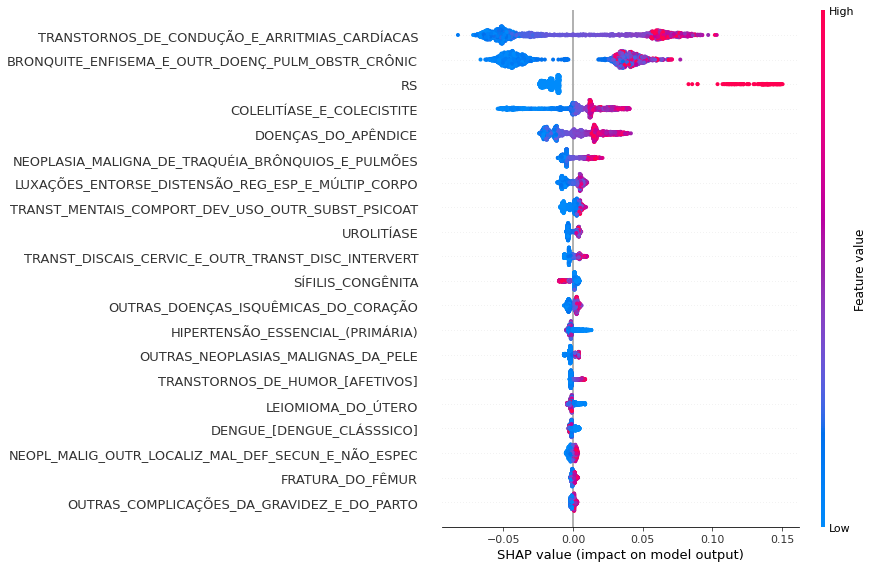

In [31]:
explainer = shap.TreeExplainer(classifier)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test)

### SHAP Individual Analysis

In [33]:
print(test_df.loc[test_df['MUNCOD'] == 355030]["TARGET"])

data_for_prediction = test_df.loc[test_df['MUNCOD'] == 355030].drop(columns=["MUNCOD", "TARGET"])
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(data_for_prediction)

3509    0
Name: TARGET, dtype: int64


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [34]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

## SVM
### LinearSVC

#### Using MinMax Scaling

In [35]:
start = time.time()
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Scaling features")
    mm = MinMaxScaler()
    mm_x = mm.fit(X_train)
    X_train = mm_x.transform(X_train)
    X_test = mm_x.transform(X_test)
    
    print("# Fitting the model")
    classifier = LinearSVC(random_state=42)
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
  
    print("\n")
    count += 1
print("=============== SUMMARY SVM LINEAR (MINMAX) ===============")

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["SVM Linear MM"] = scores

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Scaling features
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2694 1050]
 [1105 2631]]
              precision    recall  f1-score   support

           0      0.709     0.720     0.714      3744
           1      0.715     0.704     0.709      3736

    accuracy                          0.712      7480
   macro avg      0.712     0.712     0.712      7480
weighted avg      0.712     0.712     0.712      7480

Test
[[647 289]
 [312 622]]
              precision    recall  f1-score   support

           0      0.675     0.691     0.683       936
           1      0.683     0.666     0.674       934

    accuracy                          0.679      1870
   macro avg      0.679     0.679     0.679      1870
weighted avg      0.679     0.679     0.679      1870



=============== RUN 2 ===============
# Scaling features
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2683 1061]
 [1122 2614]]
          

#### Using Standard Scaling

In [36]:
start = time.time()
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Scaling features")
    sc = StandardScaler()
    sc_x = sc.fit(X_train)
    X_train = sc_x.transform(X_train)
    X_test = sc_x.transform(X_test)
    
    print("# Fitting the model")
    classifier = LinearSVC(random_state=42)
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)
  
    print("\n")
    count += 1
print("=============== SUMMARY SVM LINEAR (STANDARD) ===============")

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["SVM Linear SC"] = scores

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Scaling features
# Fitting the model


Liblinear failed to converge, increase the number of iterations.


# Making predictions
# Calculating metrics
Train
[[2640 1104]
 [1113 2623]]
              precision    recall  f1-score   support

           0      0.703     0.705     0.704      3744
           1      0.704     0.702     0.703      3736

    accuracy                          0.704      7480
   macro avg      0.704     0.704     0.704      7480
weighted avg      0.704     0.704     0.704      7480

Test
[[630 306]
 [323 611]]
              precision    recall  f1-score   support

           0      0.661     0.673     0.667       936
           1      0.666     0.654     0.660       934

    accuracy                          0.664      1870
   macro avg      0.664     0.664     0.664      1870
weighted avg      0.664     0.664     0.664      1870



=============== RUN 2 ===============
# Scaling features
# Fitting the model


Liblinear failed to converge, increase the number of iterations.


# Making predictions
# Calculating metrics
Train
[[2658 1086]
 [1141 2595]]
              precision    recall  f1-score   support

           0      0.700     0.710     0.705      3744
           1      0.705     0.695     0.700      3736

    accuracy                          0.702      7480
   macro avg      0.702     0.702     0.702      7480
weighted avg      0.702     0.702     0.702      7480

Test
[[626 310]
 [301 633]]
              precision    recall  f1-score   support

           0      0.675     0.669     0.672       936
           1      0.671     0.678     0.674       934

    accuracy                          0.673      1870
   macro avg      0.673     0.673     0.673      1870
weighted avg      0.673     0.673     0.673      1870



=============== RUN 3 ===============
# Scaling features
# Fitting the model


Liblinear failed to converge, increase the number of iterations.


# Making predictions
# Calculating metrics
Train
[[2677 1067]
 [1153 2583]]
              precision    recall  f1-score   support

           0      0.699     0.715     0.707      3744
           1      0.708     0.691     0.699      3736

    accuracy                          0.703      7480
   macro avg      0.703     0.703     0.703      7480
weighted avg      0.703     0.703     0.703      7480

Test
[[626 310]
 [322 612]]
              precision    recall  f1-score   support

           0      0.660     0.669     0.665       936
           1      0.664     0.655     0.659       934

    accuracy                          0.662      1870
   macro avg      0.662     0.662     0.662      1870
weighted avg      0.662     0.662     0.662      1870



=============== RUN 4 ===============
# Scaling features
# Fitting the model


Liblinear failed to converge, increase the number of iterations.


# Making predictions
# Calculating metrics
Train
[[2662 1082]
 [1145 2591]]
              precision    recall  f1-score   support

           0      0.699     0.711     0.705      3744
           1      0.705     0.694     0.699      3736

    accuracy                          0.702      7480
   macro avg      0.702     0.702     0.702      7480
weighted avg      0.702     0.702     0.702      7480

Test
[[618 318]
 [331 603]]
              precision    recall  f1-score   support

           0      0.651     0.660     0.656       936
           1      0.655     0.646     0.650       934

    accuracy                          0.653      1870
   macro avg      0.653     0.653     0.653      1870
weighted avg      0.653     0.653     0.653      1870



=============== RUN 5 ===============
# Scaling features
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2690 1054]
 [1165 2571]]
              precision    recall  f1-score   support

           0      0.698     0.71

Liblinear failed to converge, increase the number of iterations.


#### SHAP

# Scaling features
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2669 1075]
 [1103 2633]]
              precision    recall  f1-score   support

           0      0.708     0.713     0.710      3744
           1      0.710     0.705     0.707      3736

    accuracy                          0.709      7480
   macro avg      0.709     0.709     0.709      7480
weighted avg      0.709     0.709     0.709      7480

Test
[[643 293]
 [317 617]]
              precision    recall  f1-score   support

           0      0.670     0.687     0.678       936
           1      0.678     0.661     0.669       934

    accuracy                          0.674      1870
   macro avg      0.674     0.674     0.674      1870
weighted avg      0.674     0.674     0.674      1870

# SHAP analysis


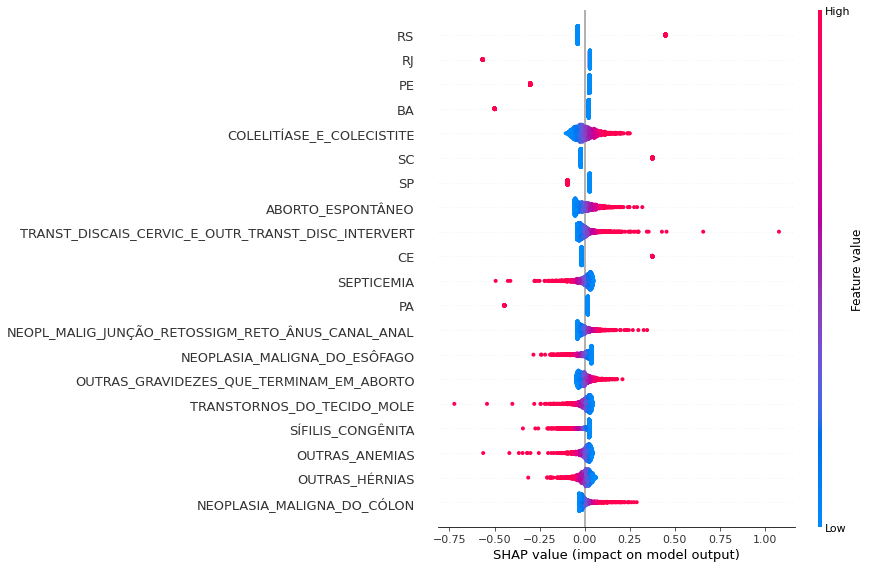

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, test_size=1/5, stratify=y)

print("# Scaling features")
mm = MinMaxScaler()
mm_x = mm.fit(X_train)
X_train = pd.DataFrame(mm_x.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(mm_x.transform(X_test), index=X_test.index, columns=X_test.columns)

print("# Fitting the model")
classifier = LinearSVC(random_state=42)
classifier.fit(X_train, y_train)

print("# Making predictions")
y_pred = classifier.predict(X_test) 
y_pred_train = classifier.predict(X_train)

print("# Calculating metrics")
calculate_metrics(y_train, y_test, y_pred, y_pred_train)

print("# SHAP analysis")
explainer = shap.LinearExplainer(classifier, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

### SVC (RBF Kernel)

#### Using MinMax Scaling

In [47]:
start = time.time()
num_feat = 30
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Scaling features")
    mm = MinMaxScaler()
    mm_x = mm.fit(X_train)
    X_train = mm_x.transform(X_train)
    X_test = mm_x.transform(X_test)
    
    print("# Bayesian Optimization")
    def train_model(params):
        C = params[0]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

        model = SVC(random_state=42,C=C)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return metrics.accuracy_score(yf_val, yf_pred)
    space = [
        (0.1,2.0), #n_estimators
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=10, n_random_starts=10)
    
    C = resultado_gp.x[0]
    
    print("# Fitting the model")
    classifier = SVC(random_state=42,C=C)
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)

    print("\n")
    count += 1
print("=============== SUMMARY SVM RBF (MINMAX) ===============")

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["SVM RBF MM"] = scores

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Scaling features
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2638 1106]
 [ 954 2782]]
              precision    recall  f1-score   support

           0      0.734     0.705     0.719      3744
           1      0.716     0.745     0.730      3736

    accuracy                          0.725      7480
   macro avg      0.725     0.725     0.724      7480
weighted avg      0.725     0.725     0.724      7480

Test
[[641 295]
 [262 672]]
              precision    recall  f1-score   support

           0      0.710     0.685     0.697       936
           1      0.695     0.719     0.707       934

    accuracy                          0.702      1870
   macro avg      0.702     0.702     0.702      1870
weighted avg      0.702     0.702     0.702      1870



=============== RUN 2 ===============
# Scaling features
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating met

#### Using Standard Scaling

In [48]:
start = time.time()
num_feat = 30
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scores = pd.DataFrame({"accuracy_train": [], "accuracy_test": [], "scores_train": [], "scores_test": []})
feature_importance_list = []
count = 1
for train_index, test_index in kf.split(X,y):
    print("=============== RUN {} ===============".format(count))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("# Scaling features")
    sc = StandardScaler()
    sc_x = sc.fit(X_train)
    X_train = sc_x.transform(X_train)
    X_test = sc_x.transform(X_test)
    
    print("# Bayesian Optimization")
    def train_model(params):
        C = params[0]

        xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

        model = SVC(random_state=42,C=C)

        model.fit(xf_train_params,yf_train_params)
        yf_pred = model.predict(xf_val)

        return metrics.accuracy_score(yf_val, yf_pred)
    space = [
        (0.1,2.0), #n_estimators
    ]
    resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=10, n_random_starts=10)
    
    C = resultado_gp.x[0]
    
    print("# Fitting the model")
    classifier = SVC(random_state=42,C=C)
    classifier.fit(X_train, y_train)
    
    print("# Making predictions")
    y_pred = classifier.predict(X_test) 
    y_pred_train = classifier.predict(X_train)
    
    print("# Calculating metrics")
    scores = calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores)

    print("\n")
    count += 1
print("=============== SUMMARY SVM RBF (STANDARD) ===============")

print("# Average Metrics")
get_average_metrics(scores)
all_models_scores["SVM RBF SC"] = scores

end = time.time()

print("\nTotal run time:", end-start)

=============== RUN 1 ===============
# Scaling features
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[2472 1272]
 [ 732 3004]]
              precision    recall  f1-score   support

           0      0.772     0.660     0.712      3744
           1      0.703     0.804     0.750      3736

    accuracy                          0.732      7480
   macro avg      0.737     0.732     0.731      7480
weighted avg      0.737     0.732     0.731      7480

Test
[[566 370]
 [224 710]]
              precision    recall  f1-score   support

           0      0.716     0.605     0.656       936
           1      0.657     0.760     0.705       934

    accuracy                          0.682      1870
   macro avg      0.687     0.682     0.680      1870
weighted avg      0.687     0.682     0.680      1870



=============== RUN 2 ===============
# Scaling features
# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating met

In [ ]:
# explainer = shap.KernelExplainer(classifier.predict_proba, shap.sample(X_train, 50), link="logit")
# shap_values = explainer.shap_values(X_test[0:30])
# shap.summary_plot(shap_values[1], X_test[0:30])

In [ ]:
# shap.initjs()
# data_for_prediction = X_test.iloc[0]
# data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
# shap_values = explainer.shap_values(data_for_prediction)
# shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

# All Models
----

Getting a summary of all training results

In [49]:
df_result_train = pd.DataFrame({"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-Score": []})

for model,scores in all_models_scores.items():
    avg_score_train = get_average(scores["scores_train"])
    avg_accuracy_train = scores["accuracy_train"].mean()
    avg_precision_train = avg_score_train[0].mean()
    avg_recall_train = avg_score_train[1].mean()
    avg_f1_score_train = avg_score_train[2].mean()
    df_result_train = df_result_train.append({"Model": model, 
                                  "Accuracy": avg_accuracy_train, "Precision": avg_precision_train,
                                  "Recall": avg_recall_train, "F1-Score": avg_f1_score_train},ignore_index=True)
df_result_train

,Model,Accuracy,Precision,Recall,F1-Score
0,Naive Bayes,0.500535,0.250267,0.500000,0.333571
1,Logistic Regression MM,0.705428,0.705452,0.705422,0.705415
2,Logistic Regression SC,0.711230,0.711263,0.711223,0.711214
3,Random Forest,0.648128,0.648552,0.648115,0.647870
4,SVM Linear MM,0.709332,0.709364,0.709326,0.709316
5,SVM Linear SC,0.702941,0.703017,0.702932,0.702907
6,SVM RBF MM,0.715936,0.716962,0.715971,0.715616
7,SVM RBF SC,0.733503,0.737768,0.733574,0.732338


Getting a summary of all testing results

In [50]:
df_result_test = pd.DataFrame({"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-Score": []})

for model,scores in all_models_scores.items():
    avg_score_test = get_average(scores["scores_test"])
    avg_accuracy_test = scores["accuracy_test"].mean()
    avg_precision_test = avg_score_test[0].mean()
    avg_recall_test = avg_score_test[1].mean()
    avg_f1_score_test = avg_score_test[2].mean()
    df_result_test = df_result_test.append({"Model": model, 
                                  "Accuracy": avg_accuracy_test, "Precision": avg_precision_test,
                                  "Recall": avg_recall_test, "F1-Score": avg_f1_score_test},ignore_index=True)
df_result_test

,Model,Accuracy,Precision,Recall,F1-Score
0,Naive Bayes,0.500535,0.250267,0.500000,0.333571
1,Logistic Regression MM,0.678289,0.678341,0.678284,0.678261
2,Logistic Regression SC,0.672299,0.672361,0.672291,0.672261
3,Random Forest,0.637968,0.638342,0.637954,0.637722
4,SVM Linear MM,0.675722,0.675781,0.675715,0.675688
5,SVM Linear SC,0.664064,0.664093,0.664059,0.664044
6,SVM RBF MM,0.687059,0.688577,0.687104,0.686453
7,SVM RBF SC,0.678824,0.683744,0.678910,0.676729


# Previsões 2018
---

Defining X and y

In [10]:
X_train = train_df.drop(columns=["TARGET"])
y_train = train_df["TARGET"]
X_test = test_df.drop(columns=["TARGET", "MUNCOD"])
y_test = test_df["TARGET"]

mm = MinMaxScaler()
X_train = mm.fit_transform(X_train)
X_test = mm.transform(X_test)

print("# Bayesian Optimization")
def train_model(params):
    C = params[0]

    xf_train_params,xf_val,yf_train_params,yf_val = train_test_split(X_train,y_train,test_size=0.33,random_state=42)

    model = SVC(random_state=42,C=C)

    model.fit(xf_train_params,yf_train_params)
    yf_pred = model.predict(xf_val)

    return metrics.accuracy_score(yf_val, yf_pred)
space = [
    (0.1,2.0), #n_estimators
]
resultado_gp = gp_minimize(train_model, space, random_state=42, verbose=0, n_calls=10, n_random_starts=10)

C = resultado_gp.x[0]

print("# Fitting the model")
classifier = SVC(random_state=42,C=C,probability=True)
classifier.fit(X_train, y_train)

print("# Making predictions")
y_pred = classifier.predict(X_test) 
y_pred_train = classifier.predict(X_train)

print("# Calculating metrics")
calculate_metrics(y_train, y_test, y_pred, y_pred_train, scores=None)

# Bayesian Optimization
# Fitting the model
# Making predictions
# Calculating metrics
Train
[[3317  895]
 [ 886 3317]]
              precision    recall  f1-score   support

           0      0.789     0.788     0.788      4212
           1      0.788     0.789     0.788      4203

    accuracy                          0.788      8415
   macro avg      0.788     0.788     0.788      8415
weighted avg      0.788     0.788     0.788      8415

Test
[[325 143]
 [140 327]]
              precision    recall  f1-score   support

           0      0.699     0.694     0.697       468
           1      0.696     0.700     0.698       467

    accuracy                          0.697       935
   macro avg      0.697     0.697     0.697       935
weighted avg      0.697     0.697     0.697       935



In [11]:
gd = gpd.read_file(root + "Maps/BRMUE250GC_SIR.shp")

mun_risk_ids_pred = test_df[y_pred == 1]['MUNCOD'].astype(int).tolist()
mun_risk_ids_true = test_df[y_test == 1]['MUNCOD'].astype(int).tolist()
mun_risk_ids_1_correct = [x for x in mun_risk_ids_pred if x in mun_risk_ids_true]

mun_risk_ids_pred_0 = test_df[y_pred == 0]['MUNCOD'].astype(int).tolist()
mun_risk_ids_true_0 = test_df[y_test == 0]['MUNCOD'].astype(int).tolist()
mun_risk_ids_0_correct = [x for x in mun_risk_ids_pred_0 if x in mun_risk_ids_true_0]

mun_risk_ids = mun_risk_ids_1_correct + mun_risk_ids_0_correct
mun_risk_ids_wrong = [x for x in mun_risk_ids_pred if x not in mun_risk_ids_true] + [x for x in mun_risk_ids_true if x not in mun_risk_ids_pred]

In [12]:
def remove_last_digit(x):
    return np.floor(x.astype(int) / 10).astype(int)

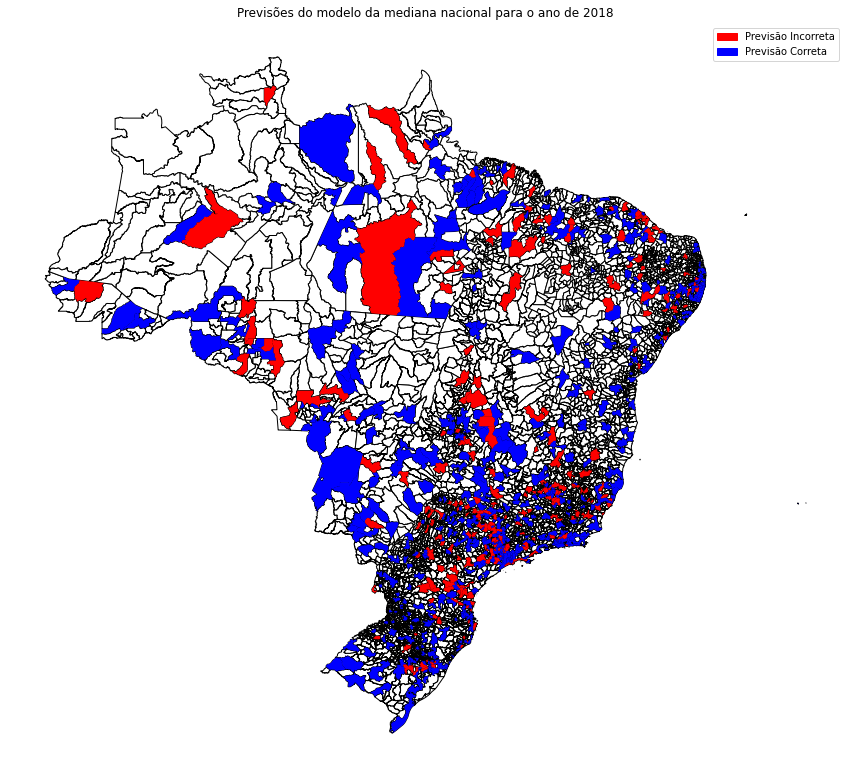

In [14]:
fig, ax = plt.subplots(figsize=(15,15))
gd.plot(ax=ax, color="white", edgecolor='black')
gd_risk = gd[remove_last_digit(gd['CD_GEOCMU']).apply(lambda x: x in mun_risk_ids)]
plot_risk = gd_risk.plot(ax=ax, color="blue")

gd_risk_wrong = gd[remove_last_digit(gd['CD_GEOCMU']).apply(lambda x: x in mun_risk_ids_wrong)]
plot_risk_wrong = gd_risk_wrong.plot(ax=ax, color="red")

blue_patch = mpatches.Patch(color='blue', label='Previsão Correta')
red_patch = mpatches.Patch(color='red', label='Previsão Incorreta')
plt.title("Previsões do modelo da mediana nacional para o ano de 2018")
plt.legend(handles=[red_patch,blue_patch])
plt.axis('off')
plt.savefig("previsoes_mediana_nacional.png")